Check if the Polaron frame hypothesis works for all points in the sphere.

In [138]:

%load_ext autoreload
%autoreload 2
import pickle
from datetime import datetime
import numpy as np
from qutip import *
import os
from matplotlib import pyplot as plt
import sys
from scipy.integrate import solve_ivp
import sandbox_correct as sb
import importlib
importlib.reload(sb)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'sandbox_correct' from '/home/saha/Desktop/tesis/colera/check_polaron_17_10/sandbox_correct.py'>

In [289]:
### Load the full dynamics from the different already calculated dynamics.

save_dir = "../energy_shift/normal_point_mid_diss"
filepath = save_dir + "/eff_coupling_6.0MHz.pkl"

with open(filepath, 'rb') as f:
    loaded_data = pickle.load(f)

for keys in loaded_data:
    print(keys)

full_dynamics_normal_shift
full_dynamics_polaron_shift
parameters
timestamp
description


In [290]:
#Get dynamics and parameters.

dynamics = loaded_data['full_dynamics_normal_shift']
parameters = loaded_data['parameters']

N = parameters['N']
cavity_diss_rate = parameters['cavity_diss_rate']
input_power = parameters['input_power']
rabi_freq = parameters['rabi_freq']
eff_coupling = parameters['eff_coupling']
qubit_targetz = parameters['qubit_targetz']
norm = parameters['norm']
final_time__mus = parameters['final_time__mus'] 
time_steps = parameters["time_steps"]
psi0_atom = parameters['initial_state_qubit']
tlist = np.linspace(0, final_time__mus, time_steps)

cavity_photon_number = 10**(input_power/10)
qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)

In [291]:
# Calculate expectations values.

d = tensor(destroy(N), qeye(2))   
sz = tensor(qeye(N), sigmaz())  
sx = tensor(qeye(N), sigmax())     
sy = tensor(qeye(N), sigmay())
sm = tensor(qeye(N), sigmam()) 


x_exp = expect(sx, dynamics)
y_exp = expect(sy, dynamics)
z_exp = expect(sz, dynamics)
photon_number = expect(d.dag()*d, dynamics)

# Qubit dynamics traced.
qubit_dynamics = np.array([ptrace(i, 1) for i in dynamics])

# Cavity dynamics traced
cavity_dynamics = np.array([ptrace(i, 0) for i in dynamics])
cavity_state_dynamics = np.array([expect(destroy(N), i) for i in cavity_dynamics])

#Calculate ground state expectation values if we cool the qubit to the polaron shifted Hamiltonian.
H_qubit_pol = sb.target_hamiltonian_polaron(parameters)
evalues_target_pol, estates_target_pol = H_qubit_pol.eigenstates()

# For ground state
gs_sigmax_pol = expect(sigmax(), estates_target_pol[0])
gs_sigmaz_pol = expect(sigmaz(), estates_target_pol[0])

# For excited state
es_sigmax_pol = expect(sigmax(), estates_target_pol[1])
es_sigmaz_pol = expect(sigmaz(), estates_target_pol[1])

# Non-polaron cavity state
cavity_initial_state = coherent(N, cavity_field)
cavity_initial_rho = cavity_initial_state @ cavity_initial_state.dag()
photon_number_normal_shift = expect(destroy(N).dag()*destroy(N), cavity_initial_rho)


In [292]:
# Hypothesis 1: Polaron shift is according to the bare Hamiltonian.

P_up = (1 + z_exp)/2        #check here if with plus or minus
P_down = (1 - z_exp)/2

rho_cavity_e_t = np.array([sb.coherent_state_dynamics(i, cavity_initial_rho , cavity_drive_amplitude, 
                        cavity_detuning + eff_coupling, cavity_diss_rate, N) for i in tlist/1e-6])
rho_cavity_g_t = np.array([sb.coherent_state_dynamics(i, cavity_initial_rho , cavity_drive_amplitude, 
                        cavity_detuning - eff_coupling, cavity_diss_rate, N) for i in tlist/1e-6])

cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)

#* np.exp(-np.abs(cavity_field_e)**2)* np.exp(-np.abs(cavity_field_g)**2) 
rho_cavity_polaron = np.array([P_up[i] * rho_cavity_e_t[i] + P_down[i] * rho_cavity_g_t[i] for i in range(len(tlist))])
#rho_cavity_polaron = np.array([i/i.norm() for i in rho_cavity_polaron])


photon_number_polaron = np.array([expect(destroy(N).dag()*destroy(N), i) for i in rho_cavity_polaron])
fidelity_bare_hamiltonian = np.array([fidelity(rho_cavity_polaron[i], cavity_dynamics[i]) for i in range(len(tlist))])

trace_distance_bare_hamiltonian = np.array([tracedist(rho_cavity_polaron[i], cavity_dynamics[i]) for i in range(len(tlist))])

In [293]:
y_exp[-1]

np.float64(-1.6881201008179394e-17)

In [294]:
#alternative

cavity_e_t = np.array([sb.coherent_field_dynamics(i, cavity_field, cavity_drive_amplitude, 
                                               cavity_detuning + eff_coupling, cavity_diss_rate, N) for i in tlist*1e-6])
cavity_g_t = np.array([sb.coherent_field_dynamics(i, cavity_field, cavity_drive_amplitude, 
                                               cavity_detuning - eff_coupling, cavity_diss_rate, N) for i in tlist*1e-6])

coherent_e_t = [coherent(N, i) for i in cavity_e_t]
coherent_g_t = [coherent(N, i) for i in cavity_g_t]

state_cavity_polaron2 = np.array([((P_up[-1]**.5)*coherent_e_t[i]+(P_down[-1]**.5)*coherent_g_t[i]) for i in range(len(tlist))])
state_cavity_polaron2 = np.array([i/i.norm() for i in state_cavity_polaron2])

#state_cavity_polaron3 = np.array([((((1+x_exp[-1])/2)**.5)*coherent_e_t[i]+(P_down[-1]**.5)*np.exp(-np.abs(cavity_field_e)**2/2)*coherent_g_t[i]) for i in range(len(tlist))])

rho_cavity_polaron2 = np.array([i*i.dag() for i in state_cavity_polaron2])
#rho_cavity_polaron2 = np.array([rho_cavity_polaron2[i] + x_exp[-1]/2*(coherent_e_t[i]*coherent_g_t[i].dag() + coherent_g_t[i]*coherent_e_t[i].dag()) for i in range(len(tlist))])

#rho_cavity_polaron2 = np.array([rho_cavity_polaron2[i] + x_exp[-1]/2*np.exp(-np.abs(cavity_field_e)**2/2 -np.abs(cavity_field_g)**2/2-np.real(np.conj(cavity_field_g))*cavity_field_e/2)*(coherent_e_t[i]*coherent_g_t[i].dag() + coherent_g_t[i]*coherent_e_t[i].dag()) for i in range(len(tlist))])

#rho_cavity_polaron2 = np.array([coherent_e_t[i]*coherent_g_t[i].dag() for i in range(len(tlist))])

photon_number_polaron2 = np.array([expect(destroy(N).dag()*destroy(N), i) for i in rho_cavity_polaron2])
fidelity_polaron2 = np.array([fidelity(rho_cavity_polaron2[i], cavity_dynamics[i]) for i in range(len(tlist))])

print(np.mean([i.norm() for i in rho_cavity_polaron2]))



1.0


In [ ]:
# Compare polaron shift with shift that would arise from our cavity Ansatz.

cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)

polaron_shift = 2*eff_coupling*np.real(cavity_field_g*np.conj(cavity_field_e))

our_shift = 2*(P_up[-1]*np.abs(cavity_field_g)**2 + P_down[-1]*np.abs(cavity_field_e)**2)

qubit_detuning_lamb_shift_ours = qubit_detuning + eff_coupling*(our_shift+ 1)

rabi_freq__N = rabi_freq/norm
qubit_detuning_lamb_shift_ours__N = qubit_detuning_lamb_shift_ours/norm


H_qubit_ours = .5*(qubit_detuning_lamb_shift_ours__N*sigmaz() + rabi_freq__N*sigmax())

evalues_ours, estates_ours = H_qubit_ours.eigenstates()

# For ground state
gs_sigmax_ours = expect(sigmax(), estates_ours[0])
gs_sigmaz_ours = expect(sigmaz(), estates_ours[0])

# For excited state
es_sigmax_ours = expect(sigmax(), estates_ours[1])
es_sigmaz_ours = expect(sigmaz(), estates_ours[1])


# Approximation: Take the final state  
P_up_final_ours = (1+gs_sigmaz_ours)/2
P_down_final_ours = (1-gs_sigmaz_ours)/2

rho_cavity_polaron_approx = np.array([P_up_final_ours * rho_cavity_e_t[i] + P_down_final_ours * rho_cavity_g_t[i] for i in range(len(tlist))])
photon_number_polaron_approx = np.array([expect(destroy(N).dag()*destroy(N), i) for i in rho_cavity_polaron_approx])
fidelity_bare_hamiltonian_approx = np.array([fidelity(rho_cavity_polaron_approx[i], cavity_dynamics[i]) for i in range(len(tlist))])

vacuum = basis(N,0)*basis(N,0).dag()
check_vacuum = np.array([fidelity(rho_cavity_polaron_approx[i], cavity_dynamics[i]) for i in range(len(tlist))])



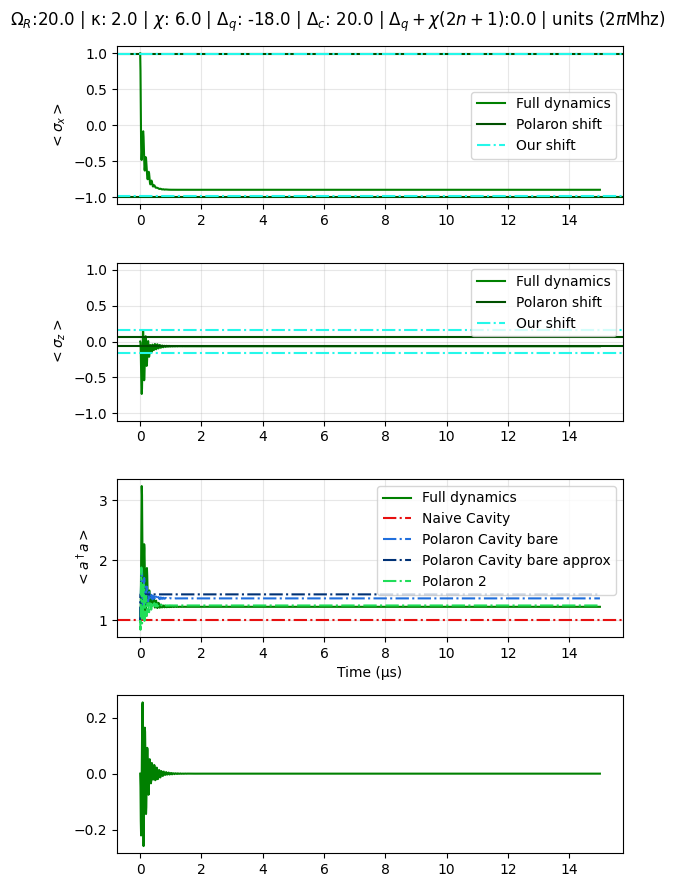

In [296]:
# Generate plot
max_time = None
if max_time is None:
    max_time = max(tlist)

time_mask = tlist <= max_time
tlist_plot = tlist[time_mask]

# Create plot
fig, axes = plt.subplots(4, 1, figsize=(6, 9))

# Plot only up to max_time
axes[0].plot(tlist_plot, x_exp[time_mask], color='#008000', label='Full dynamics')
axes[3].plot(tlist_plot, y_exp[time_mask], color='#008000', label='Full dynamics')

axes[1].plot(tlist_plot, z_exp[time_mask], color='#008000', label='Full dynamics')
axes[2].plot(tlist_plot, photon_number[time_mask], color='#008000', label='Full dynamics')

# Plot Polaron expectation values.
axes[0].axhline(gs_sigmax_pol, ls='-', color='#005000', label="Polaron shift")
axes[0].axhline(es_sigmax_pol, ls='-', color='#005000')
axes[1].axhline(gs_sigmaz_pol, ls='-', color='#005000', label="Polaron shift")
axes[1].axhline(es_sigmaz_pol, ls='-', color='#005000')

# Plor our expectation values.
axes[0].axhline(gs_sigmax_ours, ls='-.', color="#25F8EA", label="Our shift")
axes[0].axhline(es_sigmax_ours, ls='-.', color='#25F8EA')
axes[1].axhline(gs_sigmaz_ours, ls='-.', color='#25F8EA', label="Our shift")
axes[1].axhline(es_sigmaz_ours, ls='-.', color='#25F8EA')

# Plot Non-polaron photon number expectation value.
axes[2].axhline(photon_number_normal_shift, ls='-.', color="#E71010", label='Naive Cavity')


# Plot polaron photon number expectation value with cavity following bare qubit.
axes[2].plot(tlist_plot, photon_number_polaron[time_mask], ls='-.', color="#206FDD", label='Polaron Cavity bare')
axes[2].plot(tlist_plot, photon_number_polaron_approx[time_mask], ls='-.', color="#003175", label='Polaron Cavity bare approx')

axes[2].plot(tlist_plot, photon_number_polaron2[time_mask], ls='-.', color="#20DD59", label='Polaron 2')

# Format σ_x plot
axes[0].set_ylabel(r'$<\sigma_x>$')
axes[0].legend()
axes[0].set_ylim(-1.1, 1.1)
axes[0].grid(True, alpha=0.3)

# Format σ_z plot  
axes[1].set_ylabel(r'$<\sigma_z>$')
axes[1].legend()
axes[1].set_ylim(-1.1, 1.1)
axes[1].grid(True, alpha=0.3)

# Format photon number plot
axes[2].set_ylabel(r'$<a^\dagger a>$')
axes[2].set_xlabel('Time (μs)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

params_text = []
params_text.append(r"$\Omega_R$:"+f"{rabi_freq/(2*np.pi*1e6):.1f}")
params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f}")
params_text.append(r"$\chi$" + f": {eff_coupling/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_q$" + f": {qubit_detuning/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_c$" + f": {cavity_detuning/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_q +\chi(2n+1)$:"+f"{qubit_targetz/(2*np.pi*1e6):.1f}")
params_text.append(r"units (2$\pi$Mhz)")
plt.suptitle(' | '.join(params_text), y=0.98)
plt.tight_layout()


Fidelity Approximation Steady State: 0.991201008107533
Fidelity Approximation Steady State: 0.991201008107533


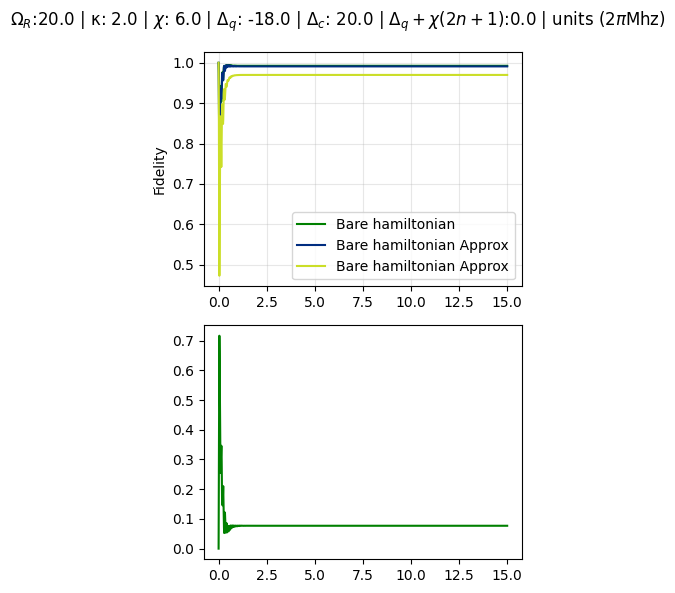

In [297]:
# Create plot
fig, axes = plt.subplots(2, 1, figsize=(4, 6))

# Plot only up to max_time
axes[0].plot(tlist_plot, fidelity_bare_hamiltonian[time_mask], color='#008000', label='Bare hamiltonian')
axes[0].plot(tlist_plot, fidelity_bare_hamiltonian_approx[time_mask], color="#002D80", label='Bare hamiltonian Approx')
axes[0].plot(tlist_plot, fidelity_polaron2[time_mask], color="#CBDE28", label='Bare hamiltonian Approx')


axes[1].plot(tlist_plot, trace_distance_bare_hamiltonian[time_mask], color="#008000", label='Bare hamiltonian Approx')


# Format fidelity plot
axes[0].set_ylabel(r'Fidelity')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

params_text = []
params_text.append(r"$\Omega_R$:"+f"{rabi_freq/(2*np.pi*1e6):.1f}")
params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f}")
params_text.append(r"$\chi$" + f": {eff_coupling/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_q$" + f": {qubit_detuning/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_c$" + f": {cavity_detuning/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_q +\chi(2n+1)$:"+f"{qubit_targetz/(2*np.pi*1e6):.1f}")
params_text.append(r"units (2$\pi$Mhz)")
plt.suptitle(' | '.join(params_text), y=0.98)
plt.tight_layout()

print("Fidelity Approximation Steady State: " + f"{fidelity_bare_hamiltonian_approx[-1]}")
print("Fidelity Approximation Steady State: " + f"{fidelity_bare_hamiltonian_approx[-1]}")

In [172]:
# Polaron frame dynamics.
cavity_e_t = np.array([sb.coherent_field_dynamics(i, cavity_field, cavity_drive_amplitude, 
                                               cavity_detuning + eff_coupling, cavity_diss_rate, N) for i in tlist*1e-6])
cavity_g_t = np.array([sb.coherent_field_dynamics(i, cavity_field, cavity_drive_amplitude, 
                                               cavity_detuning - eff_coupling, cavity_diss_rate, N) for i in tlist*1e-6])

displace_e_t = [displace(N, i) for i in cavity_e_t]
displace_g_t = [displace(N, i) for i in cavity_g_t]
projector_e = basis(2,0)*basis(2,0).dag()
projector_g = basis(2,1)*basis(2,1).dag()

polaron_trafo = [tensor(displace_e_t[i],projector_e) + tensor(displace_g_t[i],projector_g) for i in range(len(tlist))]
dynamics_polaron_frame = [polaron_trafo[i].dag()*dynamics[i]*polaron_trafo[i] for i in range(len(tlist))]

displace_np = tensor(displace(N, cavity_field),qeye(2))
dynamics_normal_displace = [displace_np.dag()*i*displace_np for i in dynamics]

x_exp_polaron_trafo = expect(sx, dynamics_polaron_frame)
z_exp_polaron_trafo = expect(sz, dynamics_polaron_frame)
photon_number_polaron_trafo = expect(d.dag()*d, dynamics_polaron_frame)

vacuum = basis(N,0)*basis(N,0).dag()
dynamics_cavity_polaron_frame = np.array([ptrace(i,0) for i in dynamics_polaron_frame])
check_vacuum = np.array([fidelity(dynamics_cavity_polaron_frame[i], vacuum) for i in range(len(tlist))])



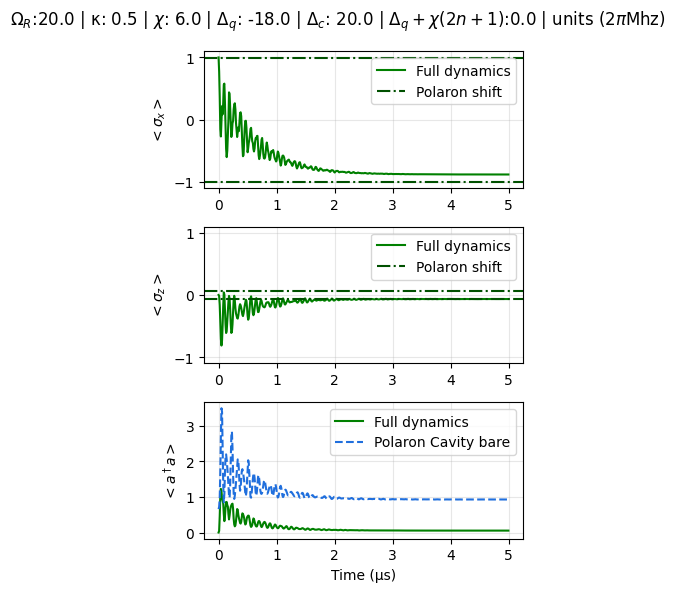

In [159]:
# Generate plot in polaron frame

max_time = 5
if max_time is None:
    max_time = max(tlist)

time_mask = tlist <= max_time
tlist_plot = tlist[time_mask]

# Create plot
fig, axes = plt.subplots(3, 1, figsize=(4, 6))

# Plot only up to max_time
axes[0].plot(tlist_plot, x_exp_polaron_trafo[time_mask], color='#008000', label='Full dynamics')
axes[1].plot(tlist_plot, z_exp_polaron_trafo[time_mask], color='#008000', label='Full dynamics')
axes[2].plot(tlist_plot, photon_number_polaron_trafo[time_mask], color='#008000', label='Full dynamics')

# Plot Polaron expectation values.
axes[0].axhline(gs_sigmax_pol, ls='-.', color='#005000', label="Polaron shift")
axes[0].axhline(es_sigmax_pol, ls='-.', color='#005000')
axes[1].axhline(gs_sigmaz_pol, ls='-.', color='#005000', label="Polaron shift")
axes[1].axhline(es_sigmaz_pol, ls='-.', color='#005000')

# Plot polaron photon number expectation value with cavity following bare qubit.
axes[2].plot(tlist_plot, photon_number[time_mask] -photon_number_polaron[time_mask], ls='--', color="#206FDD", label='Polaron Cavity bare')

# Format σ_x plot
axes[0].set_ylabel(r'$<\sigma_x>$')
axes[0].legend()
axes[0].set_ylim(-1.1, 1.1)
axes[0].grid(True, alpha=0.3)

# Format σ_z plot  
axes[1].set_ylabel(r'$<\sigma_z>$')
axes[1].legend()
axes[1].set_ylim(-1.1, 1.1)
axes[1].grid(True, alpha=0.3)

# Format photon number plot
axes[2].set_ylabel(r'$<a^\dagger a>$')
axes[2].set_xlabel('Time (μs)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

params_text = []
params_text.append(r"$\Omega_R$:"+f"{rabi_freq/(2*np.pi*1e6):.1f}")
params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f}")
params_text.append(r"$\chi$" + f": {eff_coupling/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_q$" + f": {qubit_detuning/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_c$" + f": {cavity_detuning/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_q +\chi(2n+1)$:"+f"{qubit_targetz/(2*np.pi*1e6):.1f}")
params_text.append(r"units (2$\pi$Mhz)")
plt.suptitle(' | '.join(params_text), y=0.98)
plt.tight_layout()

Fidelity Approximation Steady State: 0.9910225301449167


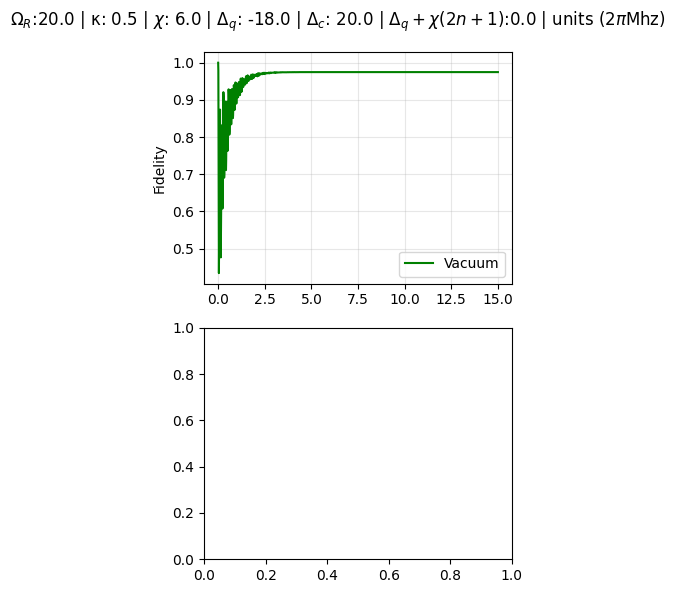

In [174]:
# Create plot
fig, axes = plt.subplots(2, 1, figsize=(4, 6))

# Plot only up to max_time
axes[0].plot(tlist_plot, check_vacuum[time_mask], color='#008000', label='Vacuum')




# Format fidelity plot
axes[0].set_ylabel(r'Fidelity')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

params_text = []
params_text.append(r"$\Omega_R$:"+f"{rabi_freq/(2*np.pi*1e6):.1f}")
params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f}")
params_text.append(r"$\chi$" + f": {eff_coupling/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_q$" + f": {qubit_detuning/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_c$" + f": {cavity_detuning/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_q +\chi(2n+1)$:"+f"{qubit_targetz/(2*np.pi*1e6):.1f}")
params_text.append(r"units (2$\pi$Mhz)")
plt.suptitle(' | '.join(params_text), y=0.98)
plt.tight_layout()

print("Fidelity Approximation Steady State: " + f"{fidelity_bare_hamiltonian_approx[-1]}")

In [13]:
# Hypothesis 2: Polaron shift is according to the dressed Hamiltonian.

cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)
qubit_detuning_lamb_shift_pol = qubit_detuning + eff_coupling*(2*np.real(cavity_field_g*np.conj(cavity_field_e))+ 1)
theta_pol = np.arctan2(rabi_freq, qubit_detuning_lamb_shift_pol)

U_pol = (1j * theta_pol/2 * sigmay()).expm()

dynamics_dressed_frame = np.array([U_pol*i*U_pol.dag() for i in qubit_dynamics])
x_exp_dressed = np.array([expect(sigmax(), i) for i in dynamics_dressed_frame])
z_exp_dressed = np.array([expect(sigmaz(), i) for i in dynamics_dressed_frame])

P_up_dressed = (1 + z_exp_dressed)/2
P_down_dressed = (1 - z_exp_dressed)/2

rho_cavity_polaron_dressed = np.array([P_up_dressed[i] * rho_cavity_e_t[i] + P_down_dressed[i] * rho_cavity_g_t[i] for i in range(len(tlist))])
photon_number_polaron_dressed = np.array([expect(destroy(N).dag()*destroy(N), i) for i in rho_cavity_polaron_dressed])

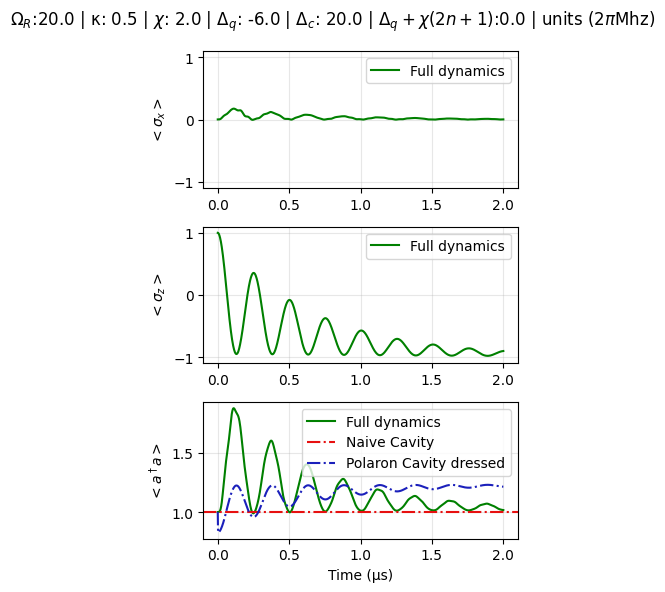

In [14]:
# Plot in the rotated frame in which the polaron qubit Hamiltonian is diagonal.

fig, axes = plt.subplots(3, 1, figsize=(4, 6))

# Plot only up to max_time
axes[0].plot(tlist_plot, x_exp_dressed[time_mask], color='#008000', label='Full dynamics')
axes[1].plot(tlist_plot, z_exp_dressed[time_mask], color='#008000', label='Full dynamics')
axes[2].plot(tlist_plot, photon_number[time_mask], color='#008000', label='Full dynamics')


# Plot Non-polaron photon number expectation value.
axes[2].axhline(photon_number_normal_shift, ls='-.', color="#E71010", label='Naive Cavity')

# Plot polaron hypothesis photon number expectation value with cavity following dressed qubit.
axes[2].plot(tlist_plot, photon_number_polaron_dressed[time_mask], ls='-.', color="#1B20BB", label='Polaron Cavity dressed')

# Format σ_x plot
axes[0].set_ylabel(r'$<\sigma_x>$')
axes[0].legend()
axes[0].set_ylim(-1.1, 1.1)
axes[0].grid(True, alpha=0.3)

# Format σ_z plot  
axes[1].set_ylabel(r'$<\sigma_z>$')
axes[1].legend()
axes[1].set_ylim(-1.1, 1.1)
axes[1].grid(True, alpha=0.3)

# Format photon number plot
axes[2].set_ylabel(r'$<a^\dagger a>$')
axes[2].set_xlabel('Time (μs)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

params_text = []
params_text.append(r"$\Omega_R$:"+f"{rabi_freq/(2*np.pi*1e6):.1f}")
params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f}")
params_text.append(r"$\chi$" + f": {eff_coupling/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_q$" + f": {qubit_detuning/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_c$" + f": {cavity_detuning/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_q +\chi(2n+1)$:"+f"{qubit_targetz/(2*np.pi*1e6):.1f}")
params_text.append(r"units (2$\pi$Mhz)")
plt.suptitle(' | '.join(params_text), y=0.98)
plt.tight_layout()

